# MASIN Flight Tracks

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from itertools import cycle
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import AnchoredText
from matplotlib.transforms import offset_copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path
import xarray as xr
from zipfile import ZipFile
# local modules
import mypaths
from common_defs import SCI_FLIGHTS, MASIN_FILE_MASK, toponyms, zoom_kw
import sat_tools
from cart import ukmo_igp_map

In [19]:
mapkw = dict(transform=ccrs.PlateCarree())
# gridline_kw = dict(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'])
svfigkw = dict(dpi=300, bbox_inches='tight')

In [3]:
color_sequence = [*[f'C{i}' for i in range(7)], '#21fc0d', '#0339f8', '#fe019a', '#fe2c54', '#1fa774', '#faee66']

## All tracks

In [4]:
gridline_kw = dict(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')
coast_kw = dict(scale='50m', facecolor='#CCCCCC', edgecolor='#888888', alpha=0.75)

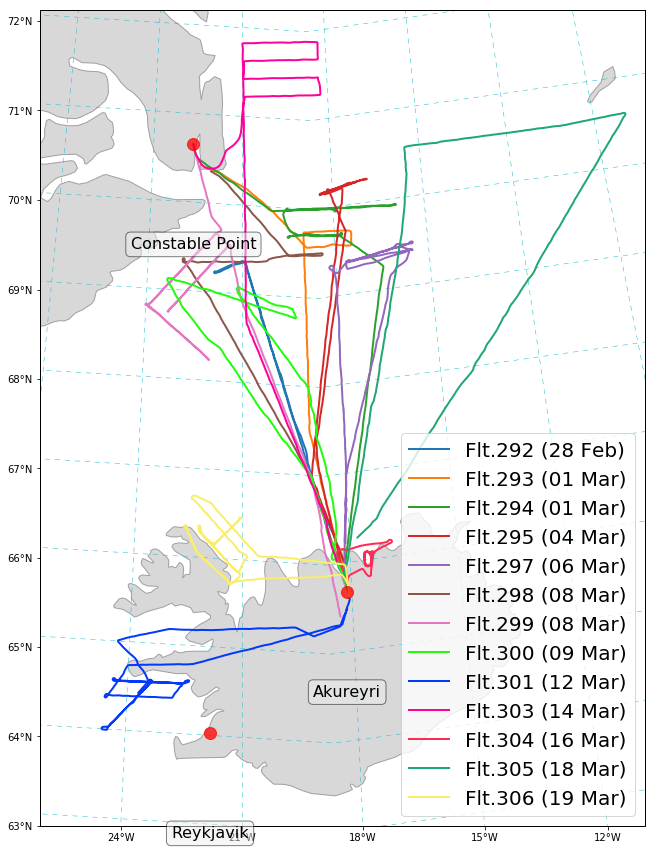

In [23]:
fig = plt.figure(figsize=(15, 15))
ax = ukmo_igp_map(fig,
                  ticks=[3,1], 
                  extent=[-26, -11, 63, 72],
                  coast=coast_kw,
                  **gridline_kw)

for color, (flight_id, flight_date_str) in zip(color_sequence, SCI_FLIGHTS.items()):
    flight_date = datetime.strptime(flight_date_str, '%Y%m%d')
    masin_data_path = (mypaths.masin_dir / f'flight{flight_id}'
                       / MASIN_FILE_MASK.format(flight_date=flight_date,
                                                flight_id=flight_id))
    ds = xr.open_dataset(masin_data_path, decode_times=False)
    x = ds.LON_OXTS[~ds.ALT_OXTS.isnull()][::10]
    y = ds.LAT_OXTS[~ds.ALT_OXTS.isnull()][::10]
        
    ax.plot(x, y, color=color, linewidth=2, **mapkw,
            label=f'Flt.{flight_id} ({flight_date:%d %b})') # , path_effects=[path_effects.withStroke(linewidth=1, foreground='k')])
ax.legend(fontsize=20);

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-svfigkw['dpi']/3)

for toponym, toponym_lonlat in toponyms.items():
    ax.plot(*toponym_lonlat, marker='o', color='red', markersize=12,
             alpha=0.75, transform=ccrs.Geodetic())
    ax.text(*toponym_lonlat, toponym,
            verticalalignment='center', horizontalalignment='center',
            transform=text_transform,
            fontsize=16,
            bbox=dict(facecolor='#EEEEEE', alpha=0.5, boxstyle='round'))

### Same, but with mean sea ice distribution

In [26]:
ostia_ds = xr.open_mfdataset(mypaths.ostia_dir.glob('*'))

In [45]:
st_date = [*SCI_FLIGHTS.values()][1]
en_date = [*SCI_FLIGHTS.values()][-1]

In [46]:
mean_sea_ice_fraction = ostia_ds.sea_ice_fraction.loc[st_date:en_date].mean('time')

In [64]:
gridline_kw = dict(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')
coast_kw = dict(scale='50m', facecolor='#CCCCCC', edgecolor='#888888', alpha=0.75)
sif_cmap = plt.cm.Blues
sif_cmap.set_under('w', alpha=0)
sif_kw = dict(extend='both', levels=np.arange(0., 1.2, 0.2), cmap=sif_cmap)

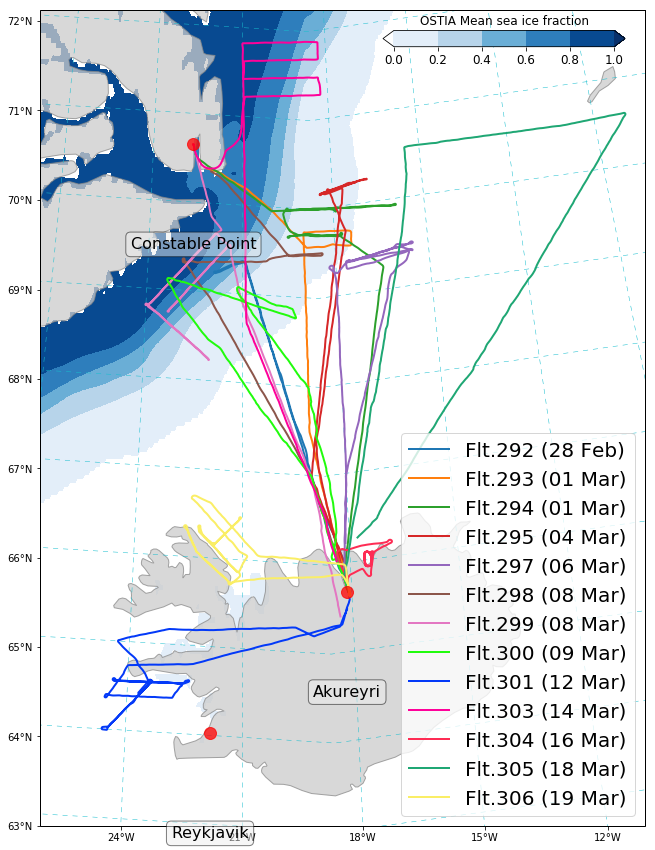

In [89]:
fig = plt.figure(figsize=(15, 15))
ax = ukmo_igp_map(fig,
                  ticks=[3,1],
                  extent=[-26, -11, 63, 72],
                  coast=coast_kw,
                  **gridline_kw)
# Add sea ice
h = ax.contourf(mean_sea_ice_fraction.lon, mean_sea_ice_fraction.lat, mean_sea_ice_fraction,
                **sif_kw, **mapkw)
cax = inset_axes(ax, borderpad=2,
                 width="40%",  # width = 10% of parent_bbox width
                 height="2%",  # height : 50%
                 loc=1)
cb = fig.colorbar(h, cax=cax, orientation='horizontal')
cb.ax.set_title('OSTIA Mean sea ice fraction')
cb.ax.tick_params(labelsize=12)

for color, (flight_id, flight_date_str) in zip(color_sequence, SCI_FLIGHTS.items()):
    flight_date = datetime.strptime(flight_date_str, '%Y%m%d')
    masin_data_path = (mypaths.masin_dir / f'flight{flight_id}'
                       / MASIN_FILE_MASK.format(flight_date=flight_date,
                                                flight_id=flight_id))
    ds = xr.open_dataset(masin_data_path, decode_times=False)
    x = ds.LON_OXTS[~ds.ALT_OXTS.isnull()][::10]
    y = ds.LAT_OXTS[~ds.ALT_OXTS.isnull()][::10]
        
    ax.plot(x, y, color=color, linewidth=2, **mapkw,
            label=f'Flt.{flight_id} ({flight_date:%d %b})') # , path_effects=[path_effects.withStroke(linewidth=1, foreground='k')])
ax.legend(fontsize=20);

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-svfigkw['dpi']/3)

for toponym, toponym_lonlat in toponyms.items():
    ax.plot(*toponym_lonlat, marker='o', color='red', markersize=12,
             alpha=0.75, transform=ccrs.Geodetic())
    ax.text(*toponym_lonlat, toponym,
            verticalalignment='center', horizontalalignment='center',
            transform=text_transform,
            fontsize=16,
            bbox=dict(facecolor='#EEEEEE', alpha=0.5, boxstyle='round'))

In [93]:
flight_date = datetime(2018, 3, 1)
flight_id = [k for k, v in SCI_FLIGHTS.items() if v==f'{flight_date:%Y%m%d}'][0]

In [94]:
masin_data_path = (mypaths.masin_dir / f'flight{flight_id}'
                   / MASIN_FILE_MASK.format(flight_date=flight_date,
                                            flight_id=flight_id))

In [95]:
ds = xr.open_dataset(masin_data_path, decode_times=False)

In [96]:
ds.coords['data_point'] = np.array([np.datetime64(flight_date.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=int(i))) for i in ds.Time.values])
ds = ds.drop('Time')
ds = ds.rename({'data_point': 'Time'})

In [97]:
flight_hours = sorted(set(ds.Time[~ds.ALT_OXTS.isnull()].dt.hour.values))
flight_hours

[8, 9, 10, 11]

In [98]:
sat_opt = dict(instrument='avhrr', platform='metopb', channel='band2_vis')

In [99]:
zfile_name = [*mypaths.sat_dir.glob(f'{flight_date:%Y%m%d}.zip')][0]

In [102]:
with ZipFile(zfile_name) as z:
    fname, timestamp = sat_tools.get_nearest_zfile(z, flight_date, **dict(instrument="viirs", platform="npp", channel="m05"))
    z.extract(fname, mypaths.sat_dir)

In [103]:
sat_image_name = mypaths.sat_dir / fname

In [104]:
im, extent, crs = sat_tools.read_raster_stereo(str(sat_image_name))

In [105]:
stride = 1

In [106]:
x = ds.LON_OXTS[~ds.ALT_OXTS.isnull()][::10]
y = ds.LAT_OXTS[~ds.ALT_OXTS.isnull()][::10]
z = ds.ALT_OXTS[~ds.ALT_OXTS.isnull()][::10]

In [107]:
cmap = plt.cm.plasma_r
cmap.set_over('#36013f')
bounds = [0, 200, 300, 500, 1000, 1500, 2000]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

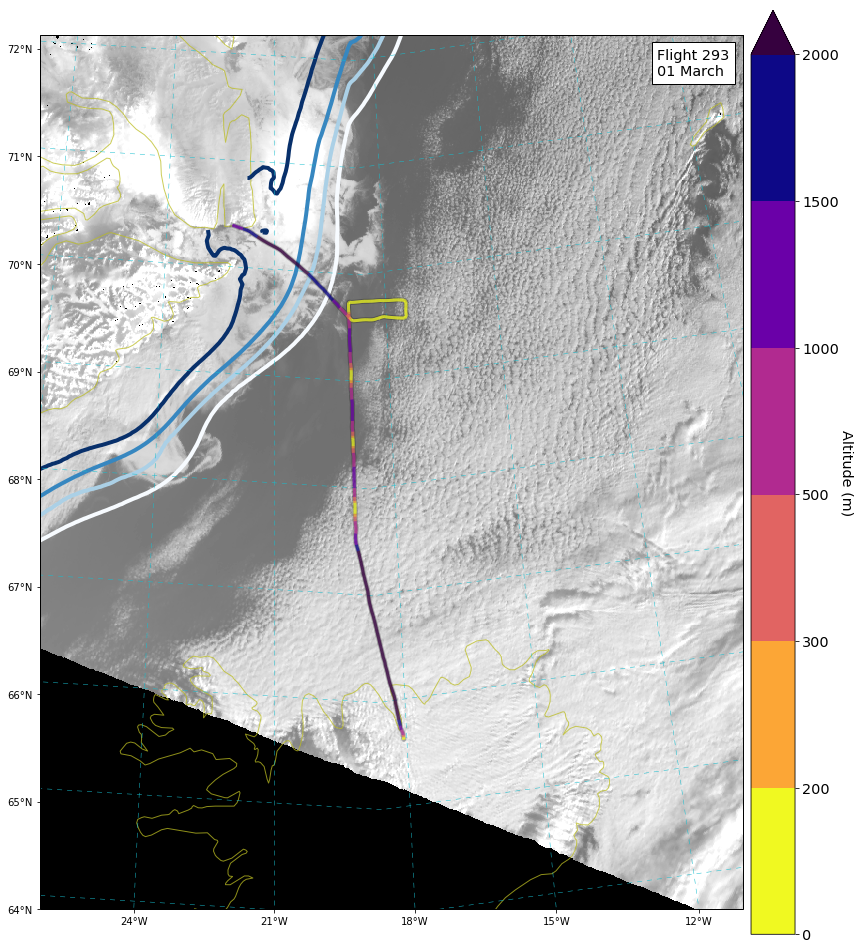

In [120]:
fig = plt.figure(figsize=(15, 17))
ax = ukmo_igp_map(fig,
                  **zoom_kw,
                  coast=dict(scale='50m', facecolor='none', edgecolor='C8', alpha=0.75),
                  **gridline_kw)

h = ax.contour(mean_sea_ice_fraction.lon, mean_sea_ice_fraction.lat, mean_sea_ice_fraction,
               **sif_kw, linewidths=4, **mapkw)
ax.clabel(h, fmt='%1.1f', **sif_kw, use_clabeltext=True, fontsize=16, inline=True)

h = ax.imshow(im[::stride, ::stride], origin='upper', extent=extent,
              transform=crs, cmap='gray', interpolation='nearest')

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

ax.plot(x, y, linewidth=5, color='k', alpha=0.25, **mapkw)
lc = LineCollection(segments, cmap=cmap, linewidth=3, zorder=10,
                    norm=norm, **mapkw)
lc.set_array(z)
h = ax.add_collection(lc)
cb = fig.colorbar(h, ax=ax, extend='max', pad=0.01)
cb.ax.tick_params(labelsize='x-large')
cb.ax.set_ylabel(f'Altitude ({z.units.strip()})', fontsize='x-large', rotation=270, labelpad=15)
at = AnchoredText(f'Flight {flight_id}\n{flight_date:%d %B}', prop=dict(size='x-large'), loc=1)
ax.add_artist(at);